# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,ambiguous,8703,81553
1,BX-E,no-author-rec,6249,7989
2,BX-E,unknown,13471,17995
3,BX-E,female,24159,45730
4,BX-E,no-book-author,7053,10744


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,152187.0,393709.0,31354.0,201904.0,132282.0,176374.0,936340.0,2024150.0
BX-E,24159.0,38299.0,8703.0,13471.0,6249.0,7053.0,21884.0,119818.0
BX-I,47390.0,72495.0,13559.0,28905.0,12853.0,13535.0,44068.0,232805.0
GR-E,27711.0,47836.0,8295.0,15609.0,4515.0,560076.0,NaN,664042.0
GR-I,27987.0,48285.0,8351.0,15810.0,4556.0,569078.0,NaN,674067.0
LOC-MDS,593959.0,2102874.0,69027.0,1176676.0,269309.0,836517.0,NaN,5048362.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,1730529.0,3199922.0,4667388.0,1276074.0,611695.0,2996508.0,4510127.0
BX-E,45730.0,64422.0,81553.0,17995.0,7989.0,10744.0,25525.0
BX-I,142311.0,172258.0,151958.0,52067.0,20973.0,28196.0,62530.0
GR-E,1359691.0,3042783.0,617525.0,647653.0,201217.0,8150256.0,NaN
GR-I,3692158.0,6760592.0,1611608.0,1773586.0,537329.0,21313230.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.075186,0.194506,0.015490,0.099748,0.065352,0.087135,0.462584
BX-E,0.201631,0.319643,0.072635,0.112429,0.052154,0.058864,0.182644
BX-I,0.203561,0.311398,0.058242,0.124160,0.055209,0.058139,0.189291
GR-E,0.041731,0.072038,0.012492,0.023506,0.006799,0.843435,NaN
GR-I,0.041520,0.071632,0.012389,0.023455,0.006759,0.844245,NaN
LOC-MDS,0.117654,0.416546,0.013673,0.233081,0.053346,0.165701,NaN


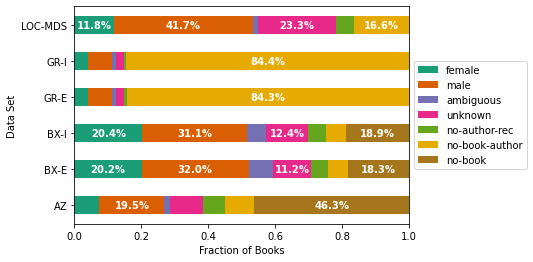

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.075186,0.194506,0.015490,0.099748,0.615071
BX-E,0.201631,0.319643,0.072635,0.112429,0.293662
BX-I,0.203561,0.311398,0.058242,0.124160,0.302640
GR-E,0.041731,0.072038,0.012492,0.023506,0.850234
GR-I,0.041520,0.071632,0.012389,0.023455,0.851004
LOC-MDS,0.117654,0.416546,0.013673,0.233081,0.219046


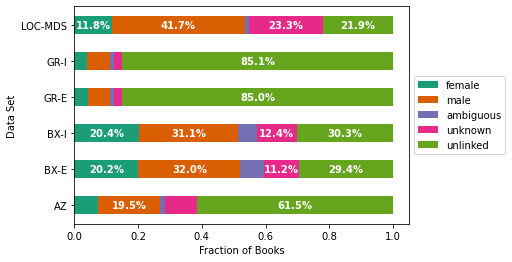

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

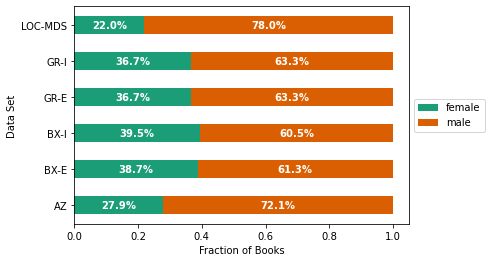

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.091118,0.168486,0.245752,0.067189,0.032208,0.157775,0.237472
BX-E,0.180069,0.253672,0.321128,0.070858,0.031458,0.042306,0.100509
BX-I,0.225785,0.273298,0.241091,0.082608,0.033275,0.044735,0.099208
GR-E,0.096988,0.217045,0.044049,0.046198,0.014353,0.581367,NaN
GR-I,0.103455,0.189433,0.045158,0.049696,0.015056,0.597202,NaN


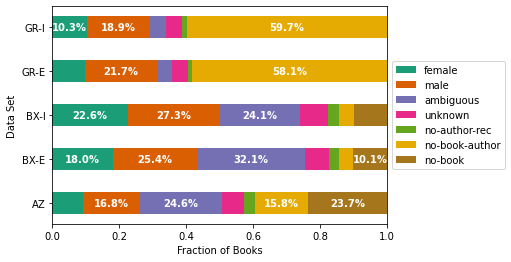

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.091118,0.168486,0.245752,0.067189,0.427455
BX-E,0.180069,0.253672,0.321128,0.070858,0.174273
BX-I,0.225785,0.273298,0.241091,0.082608,0.177218
GR-E,0.096988,0.217045,0.044049,0.046198,0.595720
GR-I,0.103455,0.189433,0.045158,0.049696,0.612258


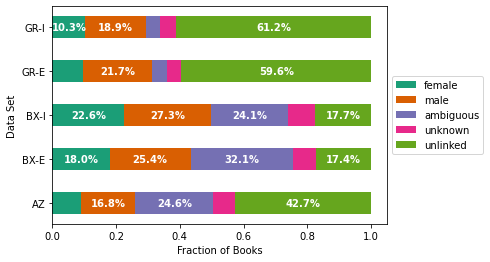

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

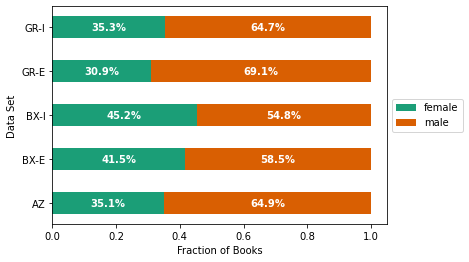

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ         0.285181
BX-E       0.593909
BX-I       0.573201
GR-E       0.126260
GR-I       0.125541
LOC-MDS    0.547873
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')